<a href="https://colab.research.google.com/github/mloyorev/Theory/blob/main/3_JobSearchModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will use the following imports:
*   **Numpy:** Python library used to work with matrices and multidimensional arrays, providing functions and tools to perform  operations.
* **Betabinom:** the betabinom function is exported from the scipy.stats module of the SciPy library, a library used to perform mathematical and statistical operations.
*   **Namedtuple:** Data type used to create a immutable class to store a set of values ​​with names associated with them.
*   **Matplotlib.pyplot:** Widely used tool in Python for creating visualizations and charts.



In [1]:
import numpy as np
from scipy.stats import betabinom
from collections import namedtuple
import matplotlib.pyplot as plt

For simplicity we create a function that implements a **successive approximation** method to solve any iterative problem

In [2]:
# We define the supremum norm as a separte function
def supremum_norm(x, x_new):
  return np.max(np.abs(x_new - x))

def successive_approx(T,                     # Operator
                      x_0,                   # Initial condition
                      M,                     # Convergence criterion
                      tolerance  = 1e-6,     # Error tolerance
                      max_iter   = 10_000,   # Max iteration bound
                      print_step = 25,       # In how many iterations a message is printed
                      verbose    = False):   # Message printing mode

    x     = x_0             # Initial condition
    error = tolerance + 1   # Initilize error
    k     = 1               # Initialize number of iterations

    while error > tolerance and k <= max_iter:                    # The algorithm keeps iterating while error > tolerance and k <= max_iter
        x_new = T(x)                                              # Apply the transoformation
        error = M(x,x_new)                                        # Updates the error with supremum_norm
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1

    if error > tolerance:                                         # If error > tolerance, then iteration hit the upper bound
        print(f"Warning: Iteration hit upper bound {max_iter}.")

    elif verbose:
        print(f"Terminated successfully in {k} iterations.")      # If verbose, then the algorithm terminates succesfully

    return x

An example to understand how does **succesive aproximation function** works is to suppose a linear operator...

$$f(x)=ax+b$$

with $\lvert a \rvert<1$.

Suppose that we start from an initial condition $x_0$ contained in the set of the real numbers, such that

$$f(x_0)=ax_0+b$$

If our objetive is to solve the linera equation $x=ax+b$, we can apply an iterative method

$$f(f(x_0))=a^{2}x_0+ab+b$$

$$f(f(x_0))=a^{3}x_0+a^{2}b+ab+b$$

$$f(f(f(x_0)))=a^{4}x_0+a^{3}b+a^{2}b+ab+b$$

In this case, by succesive approximation, we know that when $n→∞$, the solution of the liner equation is given by

$$x^*=lim_{n → ∞}(a^{n}x+b(1+a+...+a^{n}))=\frac{b}{1-a}$$

For example...

In [3]:
# Define the function f(x) = 0.3 * x + 100
def g(x):
  return 0.3 * x + 100

# Solving analitically x = 0.3 * x + 100 we have that
s_analytical = 100 / (1 - 0.3)
print('The analytical solution is:',s_analytical)

# Using succesive approximation for solving x = 0.3 * x + 100 we have that
s_sapprox = successive_approx(g, 100, supremum_norm)
print('The succesive approximation solution is:',s_sapprox)

# The difference between both solutions is given by the supremum norm
error = supremum_norm(s_analytical, s_sapprox)
print('The error of the solution by succesive approximation is:',error)

The analytical solution is: 142.85714285714286
The succesive approximation solution is: 142.8571426726569
The error of the solution by succesive approximation is: 1.844859696120693e-07


# **Job Search Model**

In this model the **optimal behavior of an unemployed worker** will be analyzed.

In this model, the **job search depends on:**


*   Current and likely wage offers.
*   Impatience.
*   Availability of unemployment compensation.



We will assume that the agent begins unemployed in period t=0. He receive a new job offer that will pay him $w_t$ in each period $t$.

The worker can carry out **two actions:**
1. Accept the job offer.
2. Reject job offer.

The objective of the agent is to **maximize the Expected Present Value (EPV) of earnings**. There are two ways to calculate EPV depending on the decision he make:
1. **If he accept the current job offer** that pays $w$, then

$$
\text{EPV} = \text{Stopping Value}= W(w)= w+\beta w+\beta^2 w+...= w/(1-\beta)
$$


2. **If he continue unemployed**, receive the unemployment insurance $c$ and receive the value of the future decisions, then

$$
\text{EPV}= \text{Continuation Value}= U = c+ \beta \sum_{w'\in W} \max\{W(w'),u\} \phi (w')
$$

Hence the unemployed worker will choose the maximum between those two options, so we have to

$$
V(w)= \max\{W(w),U\}
$$

or

$$
V(w)= \max\left\{w/(1-\beta),c+ \beta \sum_{w'\in W} max\{W(w'),u\} \phi (w')\right\}
$$

where $\phi (w')$ denotes the probability distribution function of job offers in the future paying $w^{'}$.

Given that $v(w)= max\{W(w),U\}$, the agent's value function can be expressed as follows, obtaining the Bellman equation for this model is given by

$$
V(w)= \max\left\{\frac{w}{1-\beta},c+ \beta \sum_{w'\in W} V(w') \phi (w')\right\}
$$

and the Bellman operator is

$$
    TV(w) = \max
    \left\{
        \frac{w}{1-\beta},
        c + \beta \sum_{w'} V(w') \phi(w')
    \right\}
$$

Given the succesive formulation of the worker's problem, we have that the **job search model parameters** are:


*  w_vals: Possible wage values.

*  $\phi$: Probaility distribution funtions of wages.

*  $\beta$: Discount factor.

*  $c$: Unemployment compensation.

In [4]:

model_parameters = namedtuple("Model", ("w_vals", "phi", "beta", "c"))

# Assing default values for model parameters
def create_job_search_model(
        n     = 50,    # Wage grid number of steps
        w_min = 10.0,  # Lowest wage
        w_max = 60.0,  # Highest wage
        a     = 200,   # Wage distribution parameter
        b     = 100,   # Wage distribution parameter
        beta  = 0.96,  # Discount factor
        c     = 10.0   # Unemployment compensation
    ):
    w_vals = np.linspace(w_min, w_max, n+1)                              # Since n are the number of steps, n+1 is the number of elements in the wealth grid.
    phi    = np.array([betabinom(n+1, a, b).pmf(k) for k in range(n+1)]) # Construction of the PMF of wages in the grid.
                                                                         #  - n+1 is the number of experiments.
                                                                         #  - a is directly related to the leftward bias of the distribution.
                                                                         #  - b has a direct relationship with the degree of narrowness of the distribution.

    return model_parameters(w_vals = w_vals, phi = phi, beta = beta, c = c)

As an **exercise**, let's plot the **default wage offer distribution**. In other words, let's plot the wage PMF.

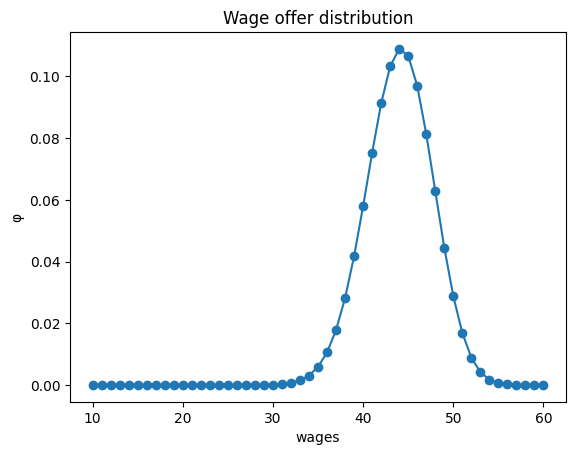

In [5]:
params = create_job_search_model(a=200,b=100)

w_vals, phi, beta, c = params
fig, ax              = plt.subplots()
ax.plot(w_vals, phi, '-o')
ax.set_xlabel("wages")
ax.set_ylabel("φ")
ax.set_title("Wage offer distribution")
plt.show()

In order to apply the VFI process, we need to **prove that our Bellman equation satisfies the Blackwell's sufficiency conditions** to be a contraction mapping.

### **1. Monotonicity**
Let $V,M$ two different functions that satisfies that $V(w)≤M(w)
$ $∀w \in W$. If we name $w'$ the wealth and the labor income shock of the next period, resvectively, then...



$$V(w')≤M(w'),  ∀w'\in W$$



If we multiply both sides of the inequality by the wealth probability, then...



$$V(w')\phi (w')≤M(w')\phi (w'),  ∀w'\in W$$



The inequality also holds for the expected value of value functions, such that...



$$\sum_{w' \in W}V(w',y')\phi (y,y')≤\sum_{w' \in W}M(w',y')\phi (y,y')$$

$$β\sum_{w' \in W}V(w')\phi (w')≤β\sum_{w' \in W}M(w')\phi (w')$$

$$c+β\sum_{w' \in W}V(w')\phi (w')≤c+β\sum_{w' \in W}M(w')\phi (w')$$



Finally we add both sides the maximization of choosing either the stoping value or the continuation value, given a particular level of  current wage such that...



$$\max\left\{\frac{w}{1-\beta}, c + \beta \sum_{w' \in W} V(w') \phi(w')\right\} ≤\max\left\{\frac{w}{1-\beta}, c + \beta \sum_{w' \in W} M(w') \phi(w')\right\},  ∀w,y$$

Therefore, $T(V(w))≤T(M(w)), ∀w \in W$, which means that the transformation **satisifes monotonicity**.

### **2. Discounting**

Let's consider a value function $V$ and a positive constant $a$, such that

$$T(V(w)+a)=\max\left\{\frac{w}{1-\beta}, c + \beta \sum_{w' \in W} (V(w')+a) \phi(w')\right\}$$



$$T(V(w)+a)=\max\left\{\frac{w}{1-\beta}, c + \beta \sum_{w' \in W} (V(w')) \phi(w')+ \beta \sum_{w' \in W} a \phi(w')\right\}$$



$$T(V(w)+a)=\max\left\{\frac{w}{1-\beta}, c + \beta \sum_{w' \in W} (V(w')) \phi(w')+ a \beta \sum_{w' \in W} \phi(w')\right\}$$



Since it is fulfilled that $\sum_{w'\in W} \phi(w')=1$, such that



$$T(V(w)+a)=\max\left\{\frac{w}{1-\beta}, c + \beta \sum_{w' \in W} (V(w')) \phi(w')+ a \beta \right\}$$



In order to analize the relation between $T(V(w)+a)$ and $ T(V(w))+\beta a$, there are **four cases**:



1.   If $T(V(w)+a)=\frac{w}{1-\beta}$  and  $T(V(w))+\beta a = \frac{w}{1-\beta} +\beta a$, then $T(V(w)+a)≤ T(V(w))+\beta a$.
2.   If $T(V(w)+a)=\frac{w}{1-\beta}$ and $T(V(w))+\beta a = c + \beta \sum_{w' \in W} (V(w')) \phi(w') +\beta a$, then , since



$$\frac{w}{1-\beta} ≤ c + \beta \sum_{w' \in W} (V(w')) \phi(w')≤ c + \beta \sum_{w' \in W} (V(w')) \phi(w') +\beta a
$$



  we can conclude that $T(V(w)+a)≤ T(V(w))+\beta a$.

3.  If $T(V(w)+a)=c + \beta \sum_{w' \in W} (V(w')) \phi(w') +\beta a$ and $T(V(w))+\beta a = \frac{w}{1-\beta} +\beta a$. Note that  



$$
c + \beta \sum_{w' \in W} (V(w')) \phi(w') < \frac{w}{1-\beta}
$$



So



$$
c + \beta \sum_{w' \in W} (V(w')) \phi(w') + \beta a < \frac{w}{1-\beta} + \beta a
$$

Concluding that $T(V(w)+a)< T(V(w))+\beta a$

4.  If $T(V(w)+a)=c + \beta \sum_{w' \in W} (V(w')) \phi(w') +\beta a$ and $T(V(w))+\beta a = c + \beta \sum_{w' \in W} (V(w')) \phi(w') +\beta a$, then



$$T(V(w)+a) = T(V(w))+\beta a$$



Therefore, $T(V(w,y)+a)≤T(V(w,y))+aβ$, which means that the transformation **satisfies discounting**.


Now we can continue designing functions for the operators in the VFI

We will desingn a function for the **Bellman operator**:

\
$$
    (Tv)(w) = \max
    \left\{
        \frac{w}{1-\beta},
        c + \beta \sum_{w'} v(w') \phi(w')
    \right\}
$$

In [6]:
# Introduce the Bellman operator
def T(v, params):
    w_vals, phi, beta, c = params             # Unpacked parameters
    h                    = c + beta * v @ phi # Get the continuation value

    return np.maximum(w_vals / (1 - beta), h) # Returns a vector in which every element is the maximum between w_vals / (1 - β) and h

Now that that's clear, we need to make a function that computes the **$v$-greedy policy**, given $v$. Such that

\

$$
v_{\text{greedy}}= \text{argmax}\left\{\frac{w}{1-\beta},c+\beta \sum_{w'} v(w') \phi(w')\right\}
$$

In [7]:
def get_greedy(v, params):
    w_vals, phi, beta, c  = params
    stopping_vals         = w_vals / (1 - beta)
    continuation_val      = c + beta * v @ phi

    return np.where(stopping_vals >= continuation_val, 1, 0) # The np.where () function creates an array containing 1 in the wage positions for which the inequality holds,
                                                             # and 0 otherwise

Then we define a function for **value function iteration** as a function that would return the value function and the greedy function on the fixed point

In [8]:
def vfi(params):
    v_0 = np.zeros_like(params.w_vals)                                                                           # Set an initial guess for the value function
    v   = successive_approx(lambda v: T(v, params), v_0, lambda x, x_new: supremum_norm(x, x_new), verbose=True) # The lambda function is used to put one function as a parameter to another.
    σ   = get_greedy(v, params)                                                                                  # Get the policy function
    return v, σ

Now let's call it using the default parameters.

In [9]:
params    = create_job_search_model()
v_star, σ = vfi(params)

Completed iteration 25 with error 5.504375849341159e-06.
Terminated successfully in 29 iterations.


It is very interesting to ask ourselves about what happens in the context of **a worker who does not receive compensation for being unemployed** $c$. Therefore we will solve the same exercise, but for $c=0$.

In [10]:
paramss     = create_job_search_model(c=0)
v_starr, σs = vfi(paramss)

Terminated successfully in 23 iterations.


Now, let's plot the **differences in optimal value functions** for both type of workers.

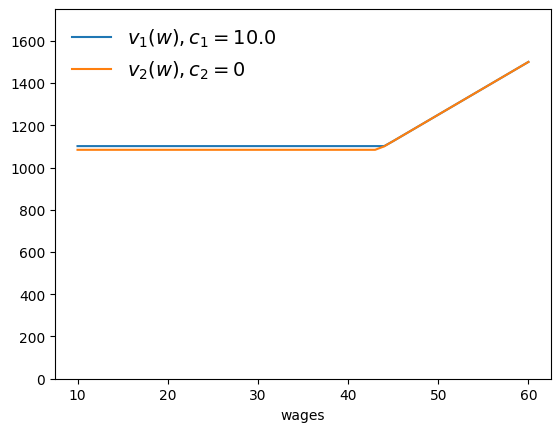

In [19]:
def plot_lifetime_value(w_vals, v_star1, v_star2, params1, params2):
    fig, ax = plt.subplots()
    ax.plot(w_vals, v_star1)
    ax.plot(w_vals, v_star2)
    ax.legend([f"$v_1(w), c_1= {params1.c}$", f"$v_2(w), c_2= {params2.c}$"], loc="upper left", frameon=False, fontsize=14)
    ax.set_xlabel("wages")
    ax.set_ylim(0, 1750)
    plt.show()

plot_lifetime_value(w_vals, v_star, v_starr, params, paramss)

In the graph above we can see that the value function with a higher unemployment compensation is greater than the value function of an agent who does not have unemployment compensation. This  means that **workers who do not receive an unemployment insurance also receive a lower EPV**.

Also here's the **optimal policy for both parameters**.

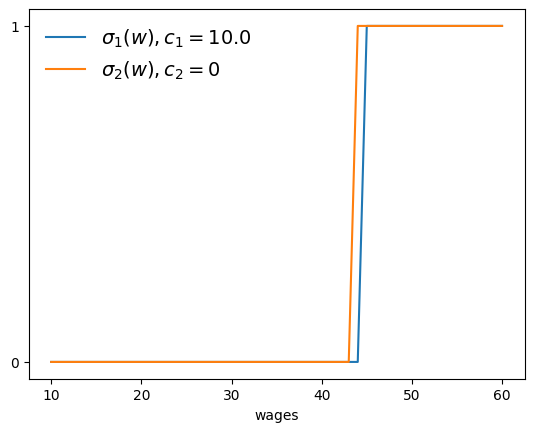

In [20]:
def plot_choices(w_vals, σ1, σ2, params1, params2):
    fig, ax = plt.subplots()
    ax.plot(w_vals, σ1)
    ax.plot(w_vals, σ2)
    ax.legend([f"$σ_1(w), c_1= {params1.c}$", f"$σ_2(w), c_2= {params2.c}$"], loc="upper left", frameon=False, fontsize=14)
    ax.set_xlabel("wages")
    ax.set_yticks((0, 1))
    plt.show()

plot_choices(w_vals, σ, σs, params, paramss)

Finally we can generate a function that performs **a complete counterfactual analysis** between workers in different circumstances, that is different model parameters.

In [21]:
def counterfactual_analysis(w_vals,params1,params2):
  # STEP I: VFI for both type of workers
  v_star1, σ1 = vfi(params1)
  v_star2, σ2 = vfi(params2)

  # STEP II: Create a graph that compute the contrasts between the lifevalue of worker 1 and worker 2
  A = plot_lifetime_value(w_vals, v_star1, v_star2, params1, params2)

  # STEP III: Create a graph that compute the contrasts between the decisions of worker 1 and worker 2
  B = plot_choices(w_vals,σ1,σ2,params1,params2)

  return A,B

For example, imagine that we want to compare the situation of two workers:



*   The first one has the default parameters.
*   The second one lives in an economy with lower wages ($b=400$), is more impatient($\beta=0.94$) and receive a lower unemployment insurance ($c=3$).



Completed iteration 25 with error 5.504375849341159e-06.
Terminated successfully in 29 iterations.
Terminated successfully in 23 iterations.


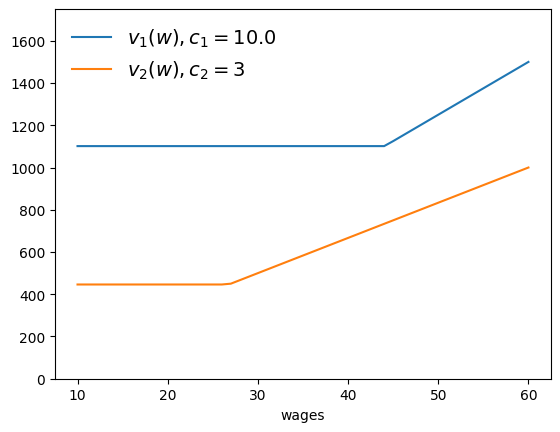

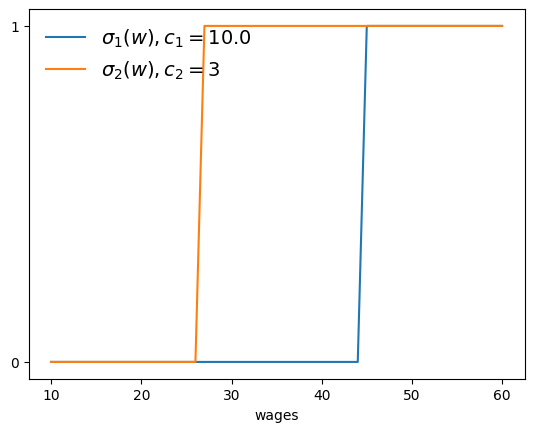

(None, None)

In [24]:
params1 = create_job_search_model()
params2 = create_job_search_model(b=400,beta=0.94,c=3)

counterfactual_analysis(w_vals,params1,params2)